## **Image Captioning with Deep Learning Trained on the Flickr8K Dataset**

*In this project, I will explore various computer vision and natural language processing (NLP) techniques to understand the context of an image and describe it in natural English. I'll develop a functional image captioning model using Convolutional Neural Networks (CNNs) for feature extraction and Long Short-Term Memory (LSTM) networks for sequence generation. The model will be trained on the Flickr8K dataset, which contains 8,000 unique images. This dataset is available for download on Kaggle.*

## 1. Importing the Required Libraries

*I'll import all the necessary Python libraries that will support image processing, data handling, and model building. This includes libraries like NumPy, 
Pandas, Seaborn, TensorFlow, PIL, and Scikit-learn.*

In [10]:
import os
import warnings
import re  # Fixed: Added missing regex import
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm  # Fixed: Replaced tqdm_notebook with tqdm
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
from collections import defaultdict  # For better data splitting

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Loading the Descriptions

*The captions file is formatted such that each line contains an image filename followed by its corresponding description. I'll load these and map each image to its descriptions using a dictionary structure.*


In [11]:
images_directory = './Images/'
captions_path = './captions.txt'

In [12]:
# 1. Load captions from CSV file (correctly handling comma separator)
def load_captions(file_path):
    captions = []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Skip the header line: 'image,caption'
    for line in lines[1:]:  # Start from index 1 to skip header
        line = line.strip()
        if not line:
            continue
        
        # Split on the first comma only (in case caption contains commas)
        if ',' in line:
            parts = line.split(',', 1)  # Split into 2 parts at the first comma
            image_id = parts[0].strip()
            caption = parts[1].strip().lower()  # Convert caption to lowercase
            captions.append((image_id, caption))
        else:
            print(f"Skipping malformed line: {line}")
    
    return captions

# Load the data
captions = load_captions('./captions.txt')
print(f"Loaded {len(captions)} captions.")

# Extract just the captions for cleaning (if needed elsewhere)
caption_texts = [cap for img_id, cap in captions]

Loaded 40455 captions.


In [13]:
captions = load_captions(captions_path)

## 3. Preprocessing the Captions

*I will remove unwanted characters such as punctuation, digits, and extra spaces, which may confuse the model.*

In [14]:
# 3. Cleaning the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply cleaning to all captions
cleaned_captions = [clean_text(caption) for _, caption in captions]

In [15]:
def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Use cleaned captions for tokenizer
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8779


## 4. Adding Start and End Tokens to Captions

*To help the model understand the beginning and end of each sentence, I'll add `start` and `end` tokens to every caption.*


In [18]:
captions_IDs = []
for image_id, _ in captions:
    # Find the corresponding cleaned caption
    original_caption = next(cap for img_id, cap in captions if img_id == image_id)
    cleaned_caption = clean_text(original_caption)
    full_caption = f"start {cleaned_caption} end"
    captions_IDs.append(f"{image_id}\t{full_caption}")

print("Sample entry:", captions_IDs[0])

Sample entry: 1000268201_693b08cb0e.jpg	start a child in a pink dress is climbing up a set of stairs in an entry way end


## 5. Visualizing Sample Images with Captions


*To better understand the dataset, I’ll visualize a few image-caption pairs. We'll create a dictionary to map image filenames to their list of captions and display them using `matplotlib`.*

In [19]:
def visualization(data, num_of_images):  # Fixed: Corrected function name spelling
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(os.path.join(images_directory, filename), target_size=(199,199))  # Fixed: Added os.path.join
        
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        
        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

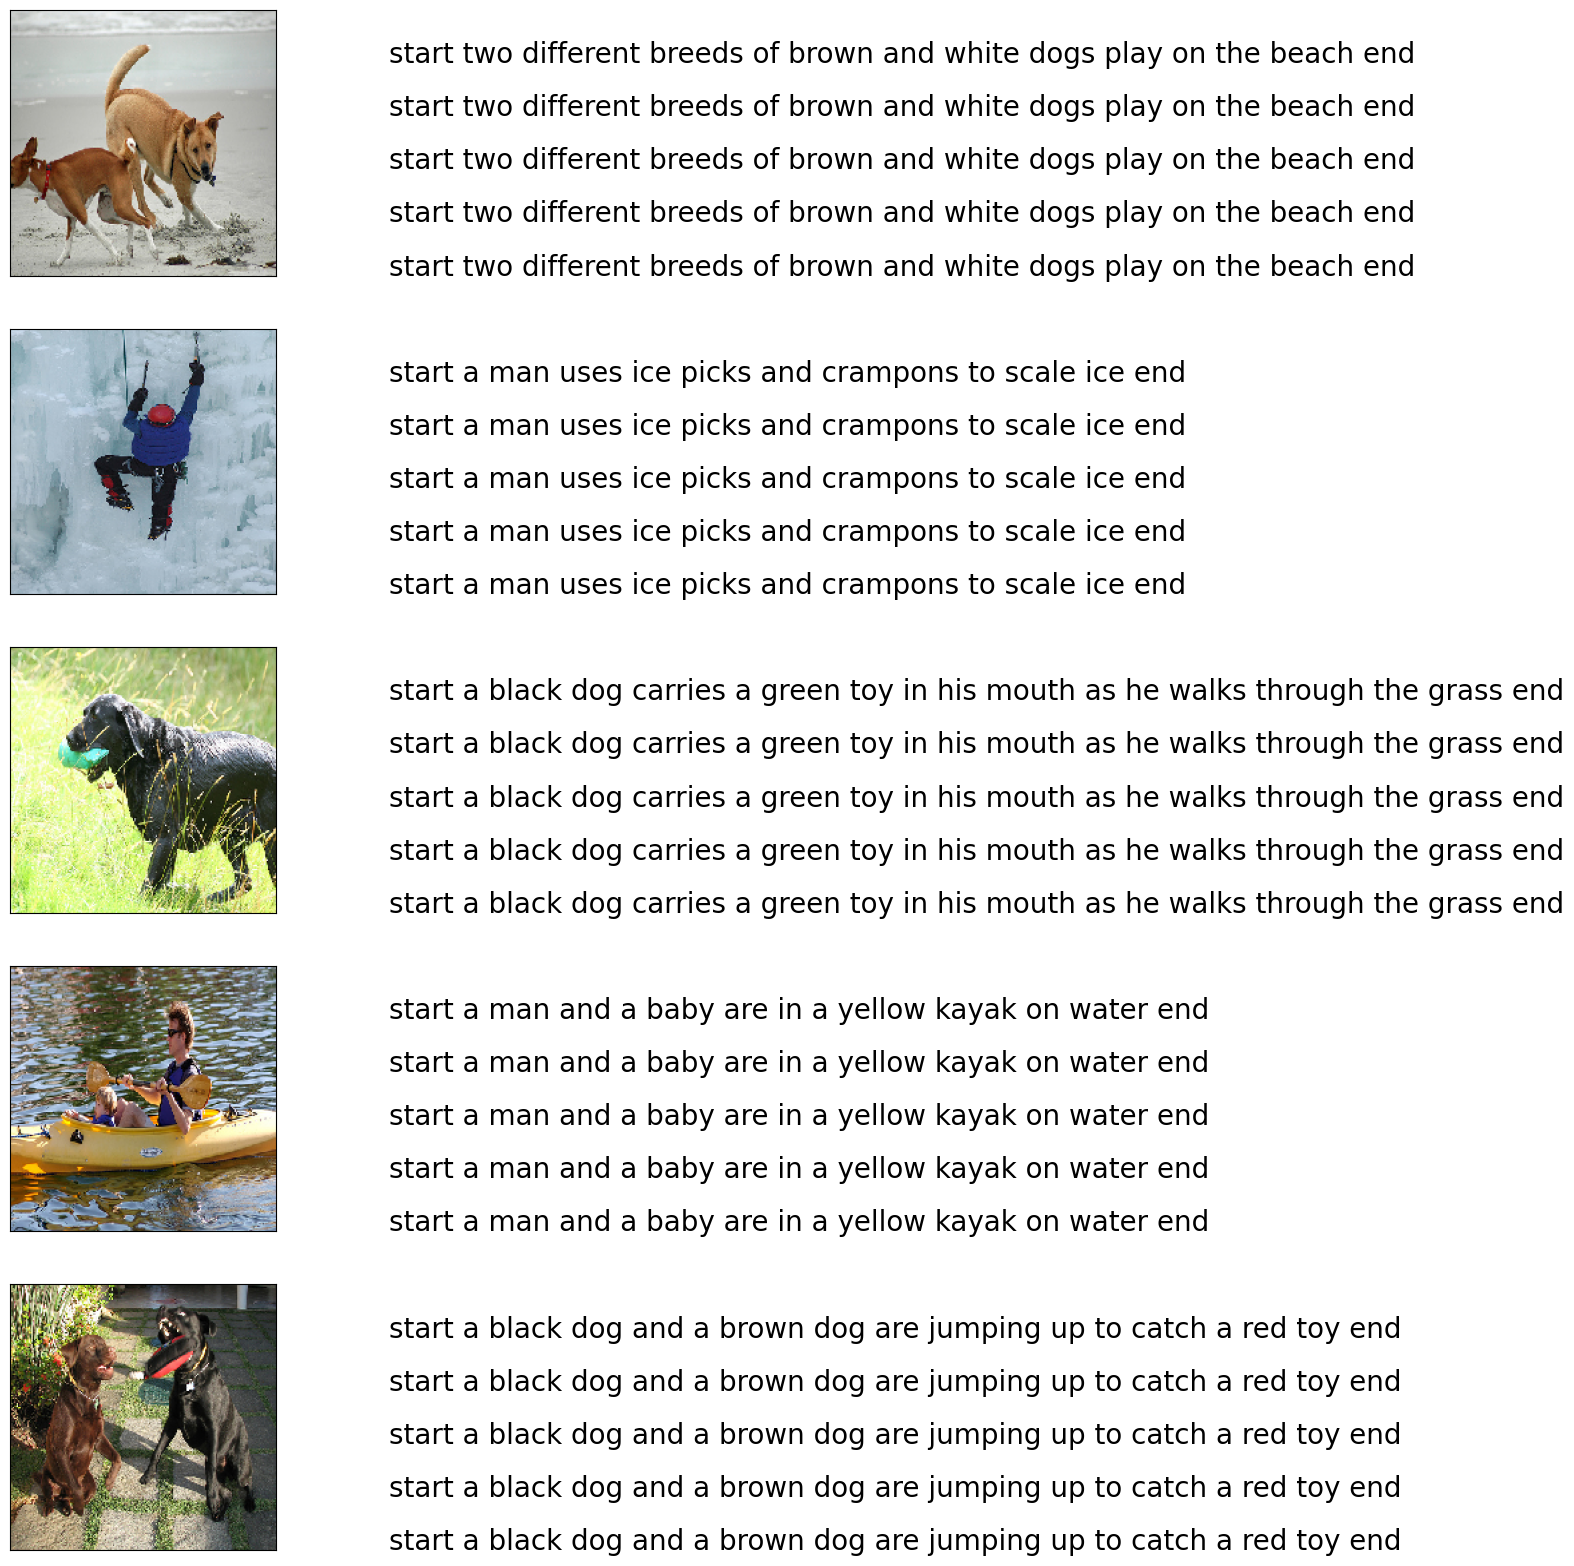

In [20]:
visualization(captions_IDs, 5)  # Uncomment to run

## 6. Analyzing Caption Length Distribution


*To determine an ideal sequence length for LSTM network, I'll visualize the distribution of caption lengths.*


In [21]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')  # Fixed: Corrected spelling
    plt.show()

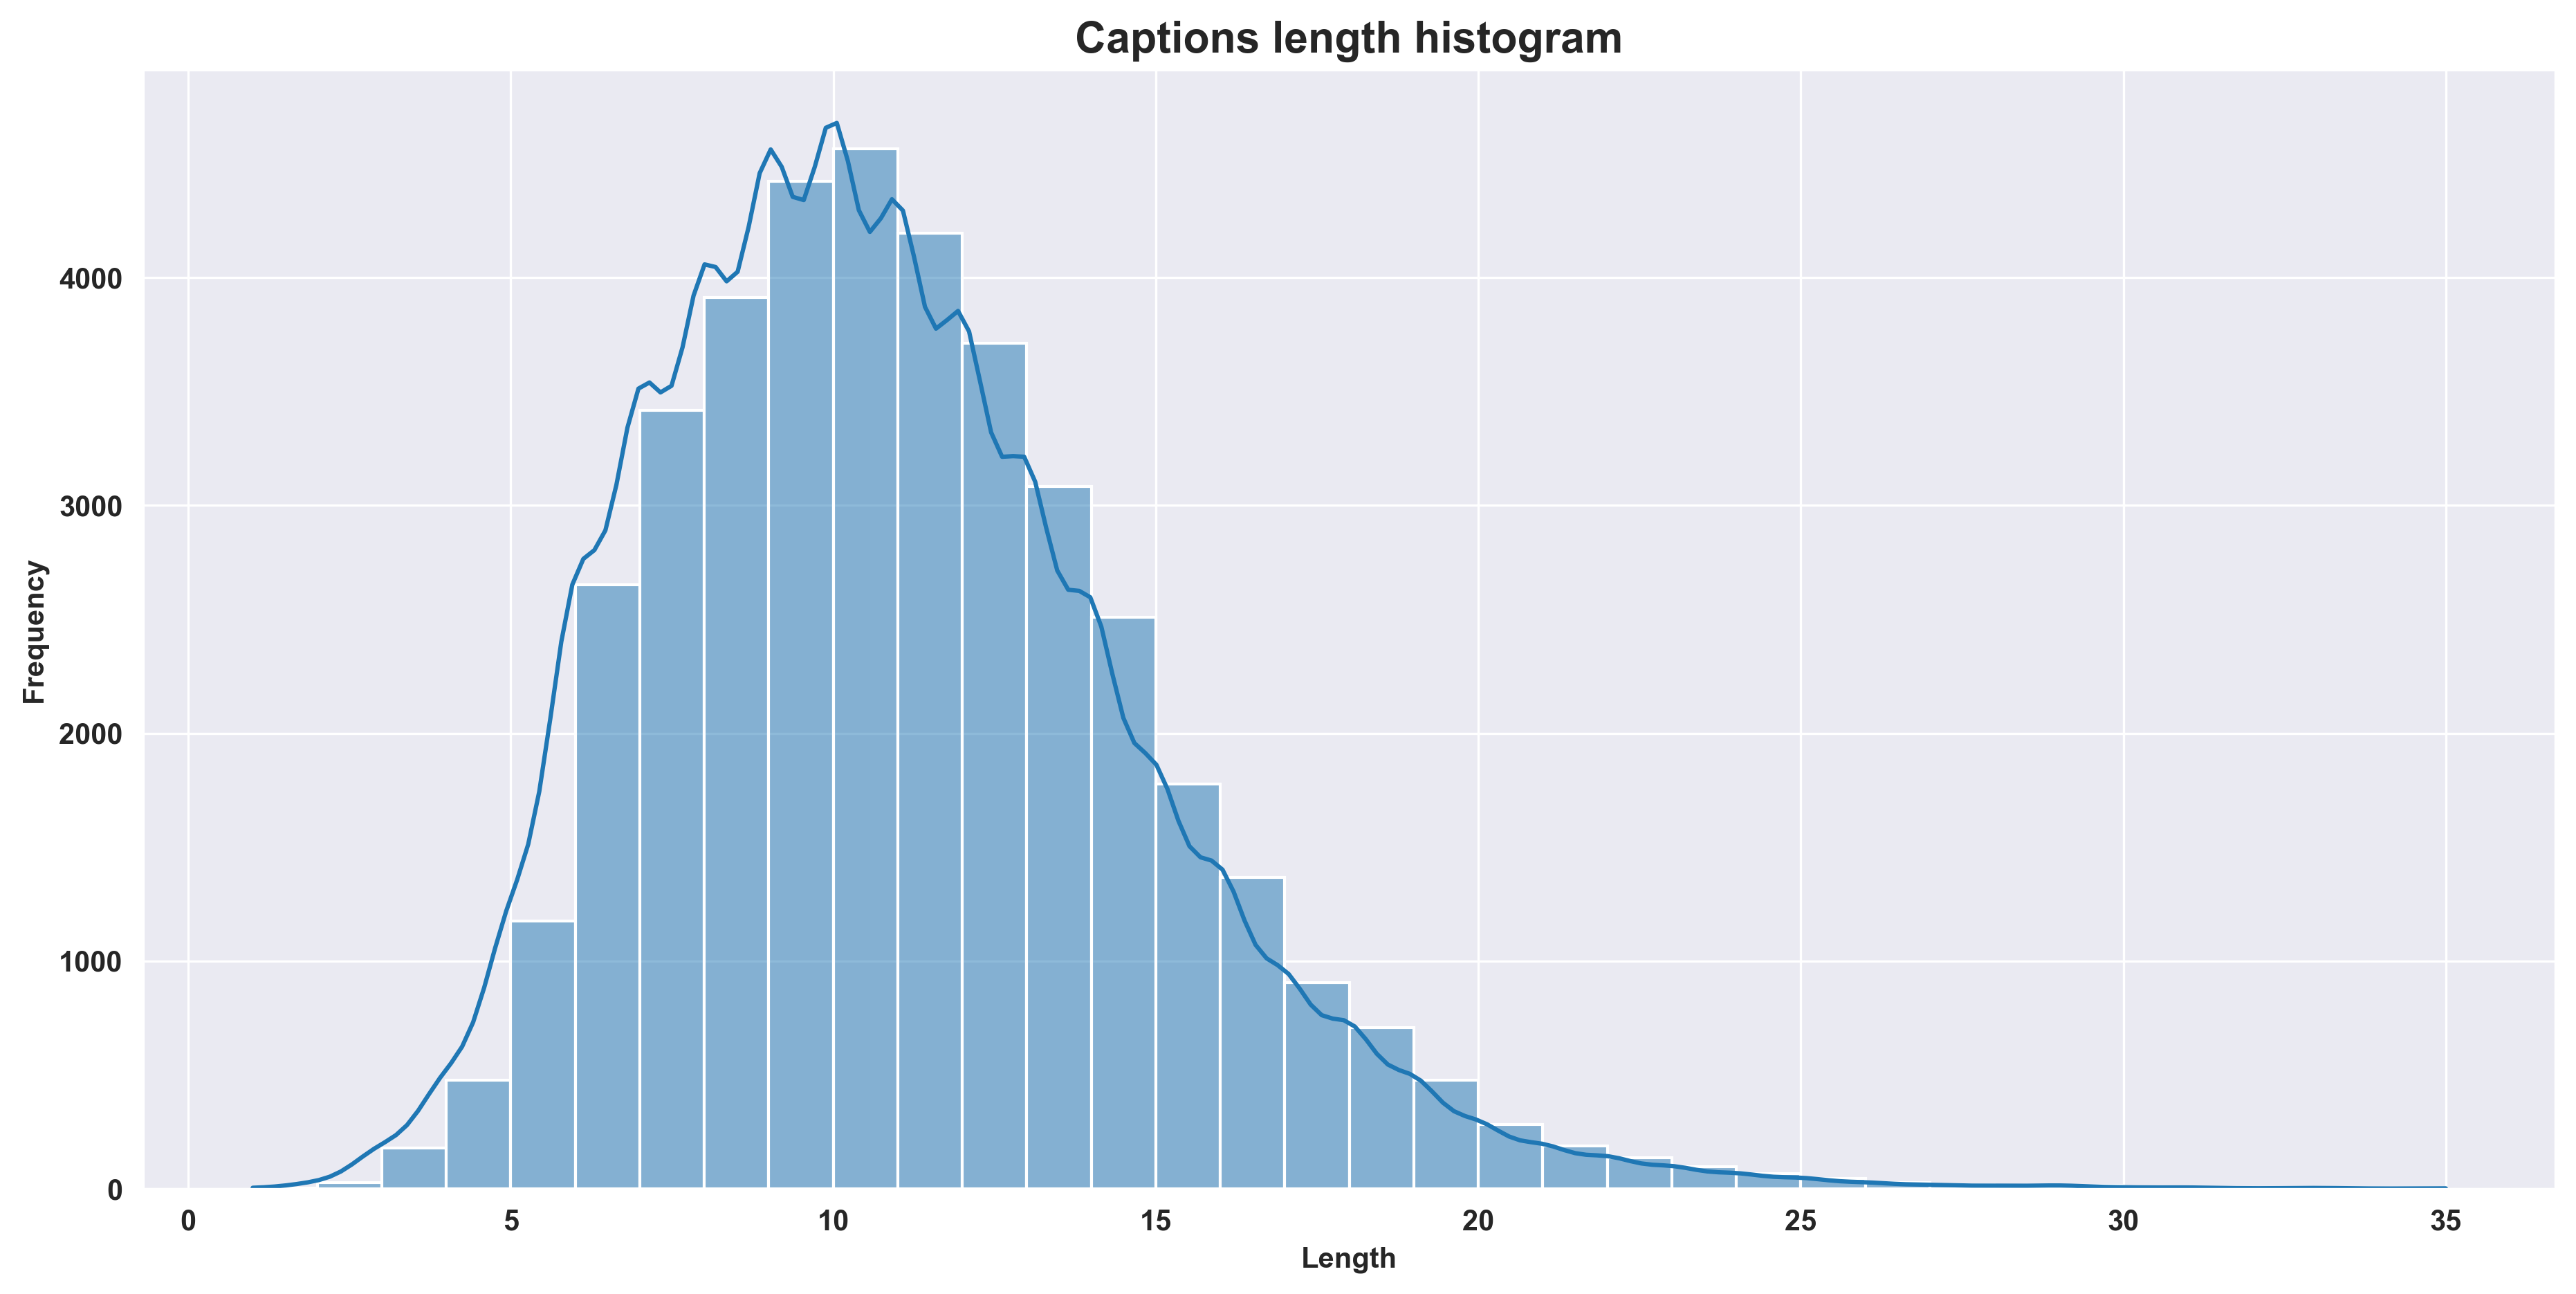

In [22]:
captions_length(cleaned_captions)  # Uncomment to run

## 7. Tokenizing the Vocabulary

*Using Keras’ `Tokenizer`, we will convert our cleaned captions into numerical sequences, which can be fed into deep learning models.*

In [23]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1

## 8. Splitting the Dataset into Train, Validation, and Test Sets


*To properly evaluate our model, I split the dataset into training, validation, and testing subsets. This helps ensure that the model generalizes well to unseen data.*


In [24]:
caption_dict = defaultdict(list)
for caption in captions_IDs:
    img_id, cap = caption.split('\t')
    caption_dict[img_id].append(cap.strip())

Get all unique image IDs

In [25]:
all_image_ids = list(caption_dict.keys())

Split the image IDs (not individual captions)

In [26]:
train_img_ids, temp_ids = train_test_split(all_image_ids, test_size=0.25, random_state=42)
val_img_ids, test_img_ids = train_test_split(temp_ids, test_size=0.2, random_state=42)

Now assign captions based on image IDs

In [27]:
train_captions = [f"{img_id}\t{cap}" for img_id in train_img_ids for cap in caption_dict[img_id]]
val_captions = [f"{img_id}\t{cap}" for img_id in val_img_ids for cap in caption_dict[img_id]]
test_captions = [f"{img_id}\t{cap}" for img_id in test_img_ids for cap in caption_dict[img_id]]

Create a test_actual_captions dictionary for evaluation

In [28]:
test_actual_captions = defaultdict(list)
for caption in test_captions:
    img_id, cap = caption.split('\t')
    test_actual_captions[img_id].append(cap)

## 9. Extracting Feature Vectors from Images


*Since machines can't "see" images as humans do, I convert images into meaningful numerical encodings using a pre-trained model. We use the `InceptionV3` model (trained on ImageNet) and discard its final classification layer to extract a 2048-dimensional feature vector for each image.*

In [29]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [30]:
def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

In [32]:
inception_v3_model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)  # Fixed: More reliable way to remove top

## 10. Extracting Features for All Dataset Subsets


*I now extract feature vectors for all images in the training, validation, and test sets using the InceptionV3 model and store them in separate dictionaries.*

In [33]:
train_image_features, val_image_features, test_image_features = {}, {}, {}

First, create a mapping of all image IDs to their paths

In [34]:
all_image_paths = {img_id: os.path.join(images_directory, img_id) for img_id in all_image_ids}

In [35]:
pbar = tqdm(total=len(all_image_ids), position=0, leave=True, colour='green')  # Fixed: Removed _notebook

  0%|          | 0/8091 [00:00<?, ?it/s]

In [36]:
for img_id in all_image_ids:
    image_path = all_image_paths[img_id]
    
    if not os.path.exists(image_path):
        continue  # Skip if image doesn't exist
        
    image_features = extract_image_features(inception_v3_model, image_path)
    
    if img_id in train_img_ids:
        train_image_features[img_id] = image_features.flatten()
    elif img_id in val_img_ids:
        val_image_features[img_id] = image_features.flatten()
    elif img_id in test_img_ids:
        test_image_features[img_id] = image_features.flatten()
    
    pbar.update(1)

100%|██████████| 8091/8091 [18:01<00:00,  4.00it/s]

In [38]:
pbar.close()

100%|██████████| 8091/8091 [22:58<00:00,  5.87it/s]


## 11. Building a Data Generator

*To train model efficiently on large datasets, I create a data generator that dynamically yields batches of input features and tokenized captions, minimizing memory usage.*

In [41]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    while True:
        # Shuffle at the start of each epoch
        np.random.shuffle(captions)
        
        X_images_batch = []
        X_captions_batch = []
        y_batch = []

        for caption in captions:
            try:
                image_id, caption_text = caption.split('\t', 1)
            except:
                continue  # Skip malformed lines

            if image_id not in image_features:
                continue

            # Tokenize caption
            seq = tokenizer.texts_to_sequences([caption_text])[0]

            # Create input-output pairs for teacher forcing
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_caption_length, value=0)[0]

                # One-hot encode output word
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X_images_batch.append(image_features[image_id])
                X_captions_batch.append(in_seq)
                y_batch.append(out_seq)

                # Yield a full batch
                if len(X_images_batch) == batch_size:
                    # FIX: Use TUPLE instead of LIST for inputs
                    yield (
                        (np.array(X_images_batch), np.array(X_captions_batch)),  # <-- CHANGED TO TUPLE
                        np.array(y_batch)
                    )
                    X_images_batch, X_captions_batch, y_batch = [], [], []

        # Don't forget the last incomplete batch
        if len(X_images_batch) > 0:
            # FIX: Use TUPLE instead of LIST for inputs
            yield (
                (np.array(X_images_batch), np.array(X_captions_batch)),  # <-- CHANGED TO TUPLE
                np.array(y_batch)
            )

Calculate max_caption_length correctly with start/end tokens

In [42]:
# Recreate full captions with start/end
full_captions = [f"start {cap} end" for cap in cleaned_captions]
max_caption_length = max(len(tokenizer.texts_to_sequences([cap])[0]) for cap in full_captions)

# max_caption_length = max(len(tokenizer.texts_to_sequences([cap])[0]) for cap in cleaned_captions) + 2  # +2 for start and end
cnn_output_dim = inception_v3_model.output_shape[1]  # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

## 12. Designing the Captioning Model


*I define a multi-input neural network architecture that takes both image features and tokenized captions to generate the next word in a sequence.*


In [43]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)
    
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)
    
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

In [44]:
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Slightly reduced learning rate
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## 13. Training the Model with Callbacks

*I train the model using early stopping to avoid overfitting and a learning rate scheduler to stabilize learning as training progresses.*

In [55]:
# Define callbacks first
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_schedule = LearningRateScheduler(lr_scheduler)

Calculate proper steps per epoch

In [56]:
steps_per_epoch = len(train_captions) // batch_size_train
validation_steps = len(val_captions) // batch_size_val

In [57]:
if steps_per_epoch == 0:
    steps_per_epoch = 1
if validation_steps == 0:
    validation_steps = 1

In [58]:
history = caption_model.fit(
    train_data_generator, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_generator, 
    validation_steps=validation_steps,
    epochs=15, 
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - loss: 3.1768 - val_loss: 3.8120 - learning_rate: 0.0010
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - loss: 3.0470 - val_loss: 3.7263 - learning_rate: 0.0010
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - loss: 2.8709 - val_loss: 3.8000 - learning_rate: 0.0010
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 2.7037 - val_loss: 3.8106 - learning_rate: 0.0010
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 2.6047 - val_loss: 3.8714 - learning_rate: 0.0010


## 14. Visualizing Loss Curves

*Plotting training and validation loss helps us understand how well our model is learning and whether it is overfitting.*

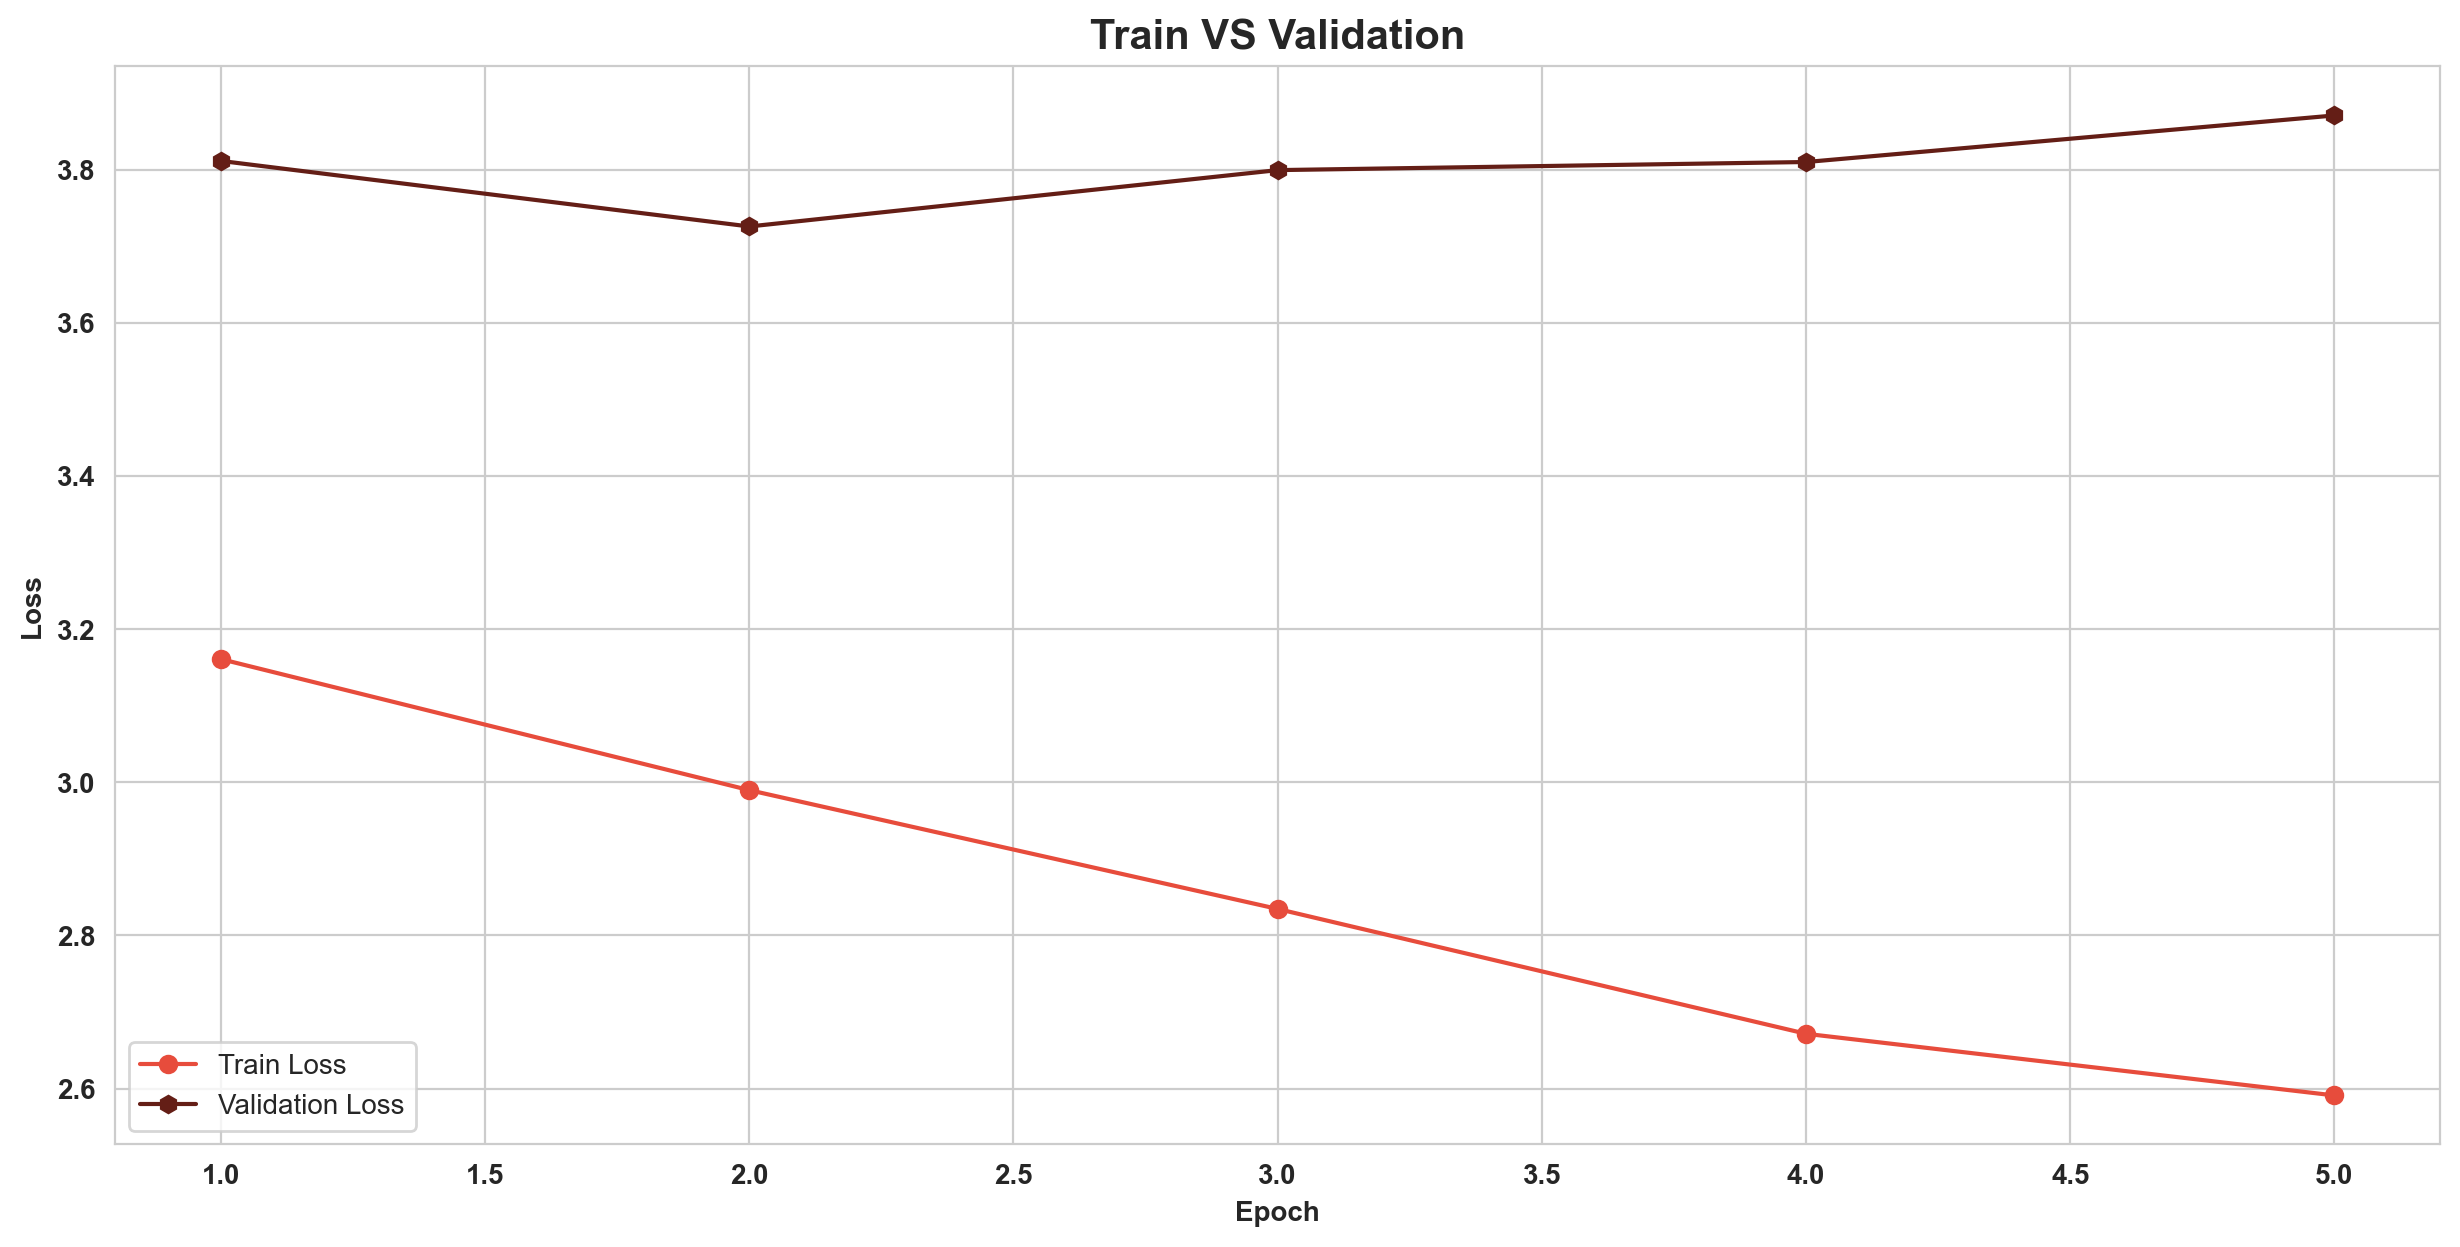

In [59]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

## 15. Caption Generation with Greedy Search

*Greedy search generates captions by choosing the most probable word at each time step until the end token is predicted.*

In [90]:
def greedy_generator(image_features, max_length=None):
    if max_length is None:
        max_length = max_caption_length
    
    in_text = 'start'
    generated_words = []
    
    for _ in range(max_length):
        # Prepare sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)[0]
        sequence = np.array([sequence])
        
        # Get prediction
        prediction = caption_model.predict(
            [image_features.reshape(1, cnn_output_dim), sequence], 
            verbose=0
        )
        
        # Apply n-gram repetition penalty (THIS IS CRITICAL)
        if len(generated_words) >= 2:
            # Check for 2-gram repetition
            current_bigram = (generated_words[-2], generated_words[-1])
            if len(generated_words) >= 4:
                previous_bigram = (generated_words[-4], generated_words[-3])
                if current_bigram == previous_bigram:
                    # Penalize the repeated word
                    word_idx = tokenizer.word_index.get(generated_words[-1], 0)
                    if word_idx < len(prediction[0]):
                        prediction[0][word_idx] *= 0.3  # Strong penalty
        
        # Get the next word with repetition prevention
        idx = np.argmax(prediction[0])
        word = tokenizer.index_word.get(idx, '')
        
        # Break if we hit 'end' or repetition continues
        if word == 'end' or not word or (len(generated_words) > 0 and word == generated_words[-1] and len(generated_words) > 3):
            break
            
        generated_words.append(word)
        in_text += ' ' + word
    
    return ' '.join(generated_words).strip()

## 16. Caption Generation with Beam Search

*Beam search enhances the quality of generated captions by keeping multiple candidate sequences at each step instead of selecting the highest probability word alone.*



In [91]:
def beam_search_generator(image_features, K_beams=3, max_length=35):
    start = tokenizer.texts_to_sequences(['start'])[0]
    sequences = [[start, 0.0]]  # [sequence, log_probability_score]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            sequence = pad_sequences([seq], maxlen=max_length)[0]
            sequence = np.array([sequence])

            preds = caption_model.predict([image_features.reshape(1, -1), sequence], verbose=0)[0]
            # Get the top K_beams words
            top_indices = np.argsort(preds)[-K_beams:]

            for idx in top_indices:
                # Avoid repeating the same word consecutively
                if len(seq) > 0 and idx == seq[-1]:
                    continue
                next_seq = seq + [idx]
                # Use log probabilities to prevent underflow
                next_score = score + np.log(preds[idx] + 1e-10)  # Add small epsilon to avoid log(0)
                all_candidates.append([next_seq, next_score])

        # Sort all candidates by score (descending) and select the top K_beams
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:K_beams]

        # Check for completed sequences
        completed = [s for s in sequences if tokenizer.index_word.get(s[0][-1], '') == 'end']
        if completed:
            # Return the best completed sequence
            best_seq = max(completed, key=lambda x: x[1])[0]
            break
    else:
        # If no sequence ended with 'end', return the best incomplete sequence
        best_seq = max(sequences, key=lambda x: x[1])[0]

    # Convert indices to words
    words = []
    for idx in best_seq:
        word = tokenizer.index_word.get(idx, '')
        if word == 'end' or word == '' or word == 'start':
            continue
        words.append(word)
    return ' '.join(words)

## 17. Evaluating Captions Using BLEU Score

*BLEU scores assess the similarity between generated and reference captions, providing a quantitative evaluation metric.*


In [92]:
def BLEU_score_simple(actual, greedy, beam_search):
    """
    Calculate BLEU scores using simple whitespace tokenization
    (avoids NLTK resource issues completely)
    """
    # Simple whitespace tokenization
    def simple_tokenize(text):
        if isinstance(text, list) and len(text) > 0:
            text = text[0]
        if not isinstance(text, str):
            text = str(text)
        # Clean the text
        text = text.lower().replace('start', '').replace('end', '').strip()
        return text.split()
    
    # Tokenize reference captions
    references = []
    if isinstance(actual, dict):
        for caps in actual.values():
            for cap in caps:
                references.append(simple_tokenize(cap))
    else:
        for cap in actual:
            references.append(simple_tokenize(cap))
    
    # Tokenize generated captions
    greedy_tokens = simple_tokenize(greedy)
    beam_tokens = simple_tokenize(beam_search)
    
    # Calculate BLEU scores
    if not references or not greedy_tokens or not beam_tokens:
        return [
            "BLEU scores not available",
            f"Greedy: {greedy}",
            f"Beam Search: {beam_search}"
        ]
    
    try:
        from nltk.translate.bleu_score import corpus_bleu
        
        # BLEU-1 (unigram)
        score_greedy_1 = corpus_bleu([references], [greedy_tokens], weights=(1, 0, 0, 0))
        score_beam_1 = corpus_bleu([references], [beam_tokens], weights=(1, 0, 0, 0))
        
        # BLEU-2 (bigram)
        score_greedy_2 = corpus_bleu([references], [greedy_tokens], weights=(0.5, 0.5, 0, 0))
        score_beam_2 = corpus_bleu([references], [beam_tokens], weights=(0.5, 0.5, 0, 0))
        
        return [
            f'BLEU-1 Greedy: {score_greedy_1:.4f}',
            f'BLEU-2 Greedy: {score_greedy_2:.4f}',
            f'Greedy: {greedy}',
            f'BLEU-1 Beam Search: {score_beam_1:.4f}',
            f'BLEU-2 Beam Search: {score_beam_2:.4f}',
            f'Beam Search: {beam_search}'
        ]
    except Exception as e:
        print(f"BLEU calculation error: {e}")
        return [
            "BLEU scores not available",
            f"Greedy: {greedy}",
            f"Beam Search: {beam_search}"
        ]

## 18. Generating Captions for Test Set


*I apply our greedy caption generator on the test images and store the results for evaluation.*

In [93]:
generated_captions = {}

In [94]:
pbar = tqdm(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

  0%|          | 0/405 [00:00<?, ?it/s]

100%|██████████| 405/405 [07:28<00:00,  1.34it/s]

In [95]:
pbar.close()

100%|██████████| 405/405 [09:45<00:00,  1.45s/it]


## 19. Visualizing the Caption Generation Results


*I display sample test images along with their true captions, greedy and beam-generated captions, and their BLEU scores.*

In [96]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images=5):
    """Visualize test images with their generated captions and BLEU scores"""
    # Get valid image IDs that exist in both data and test_image_features
    valid_image_ids = [img_id for img_id in data.keys() 
                      if img_id in test_image_features]
    
    if not valid_image_ids:
        print("No valid images found for visualization")
        return
    
    # Take the first num_of_images valid images
    images = valid_image_ids[:min(num_of_images, len(valid_image_ids))]
    fig = plt.figure(figsize=(15, 5 * len(images)))
    
    for i, filename in enumerate(images):
        actual_cap = data[filename]
        
        # Get image features
        features = test_image_features[filename]
        
        # Generate captions
        greedy_cap = greedy_caps.get(filename, "No caption generated")
        beamS_cap = beamS_generator(features)
        
        # Get BLEU scores
        try:
            caps_with_score = evaluator(actual_cap, greedy_cap, beamS_cap)
        except Exception as e:
            print(f"Error evaluating {filename}: {e}")
            caps_with_score = [
                "BLEU scores not available",
                f"Greedy: {greedy_cap}",
                f"Beam Search: {beamS_cap}"
            ]
        
        # Display image
        image_path = os.path.join(images_directory, filename)
        if os.path.exists(image_path):
            image_load = load_img(image_path, target_size=(299, 299))
            ax = fig.add_subplot(len(images), 2, 2*i+1, xticks=[], yticks=[])
            ax.imshow(image_load)
            ax.set_title(filename)
            
            # Display captions and scores
            ax = fig.add_subplot(len(images), 2, 2*i+2)
            plt.axis('off')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, len(caps_with_score) + 1)
            
            for j, text in enumerate(caps_with_score):
                ax.text(0, len(caps_with_score) - j, text, fontsize=12)
        else:
            print(f"Image not found: {image_path}")
    
    plt.tight_layout()
    plt.show()

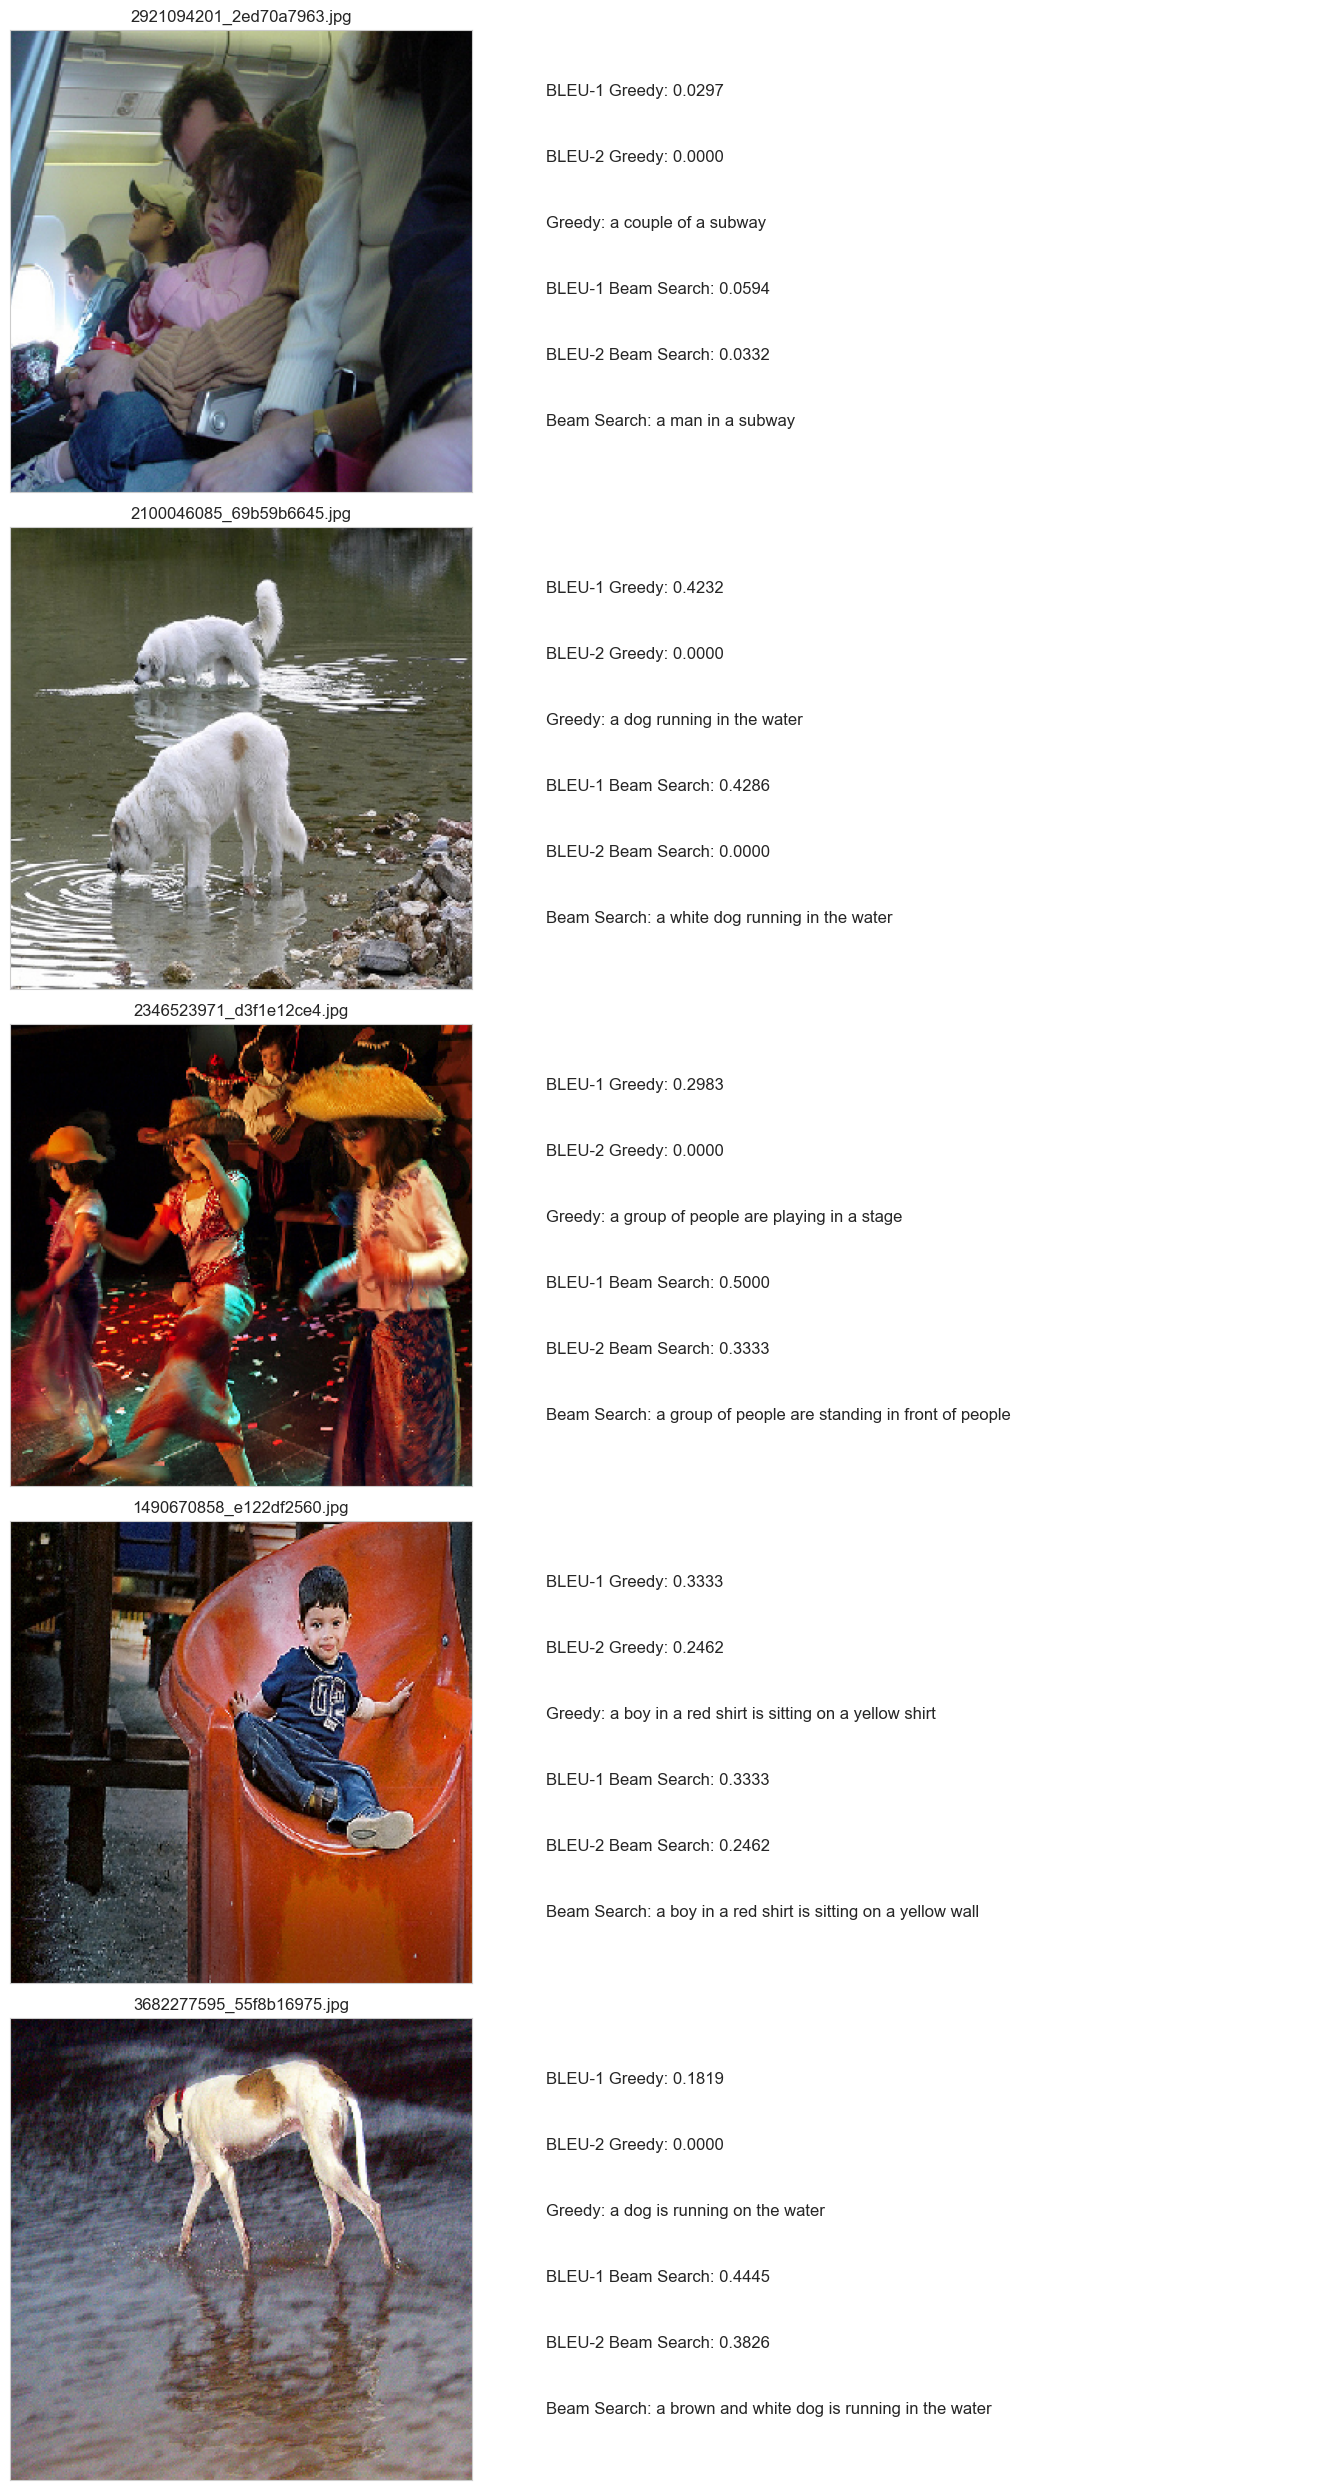

In [97]:

    
visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score_simple, 5)


# 20.Save the model

In [99]:
# Save the model in the recommended native Keras format
caption_model.save('image_captioning_model.keras')  # ✅ Preferred format

# Save the tokenizer as JSON (this part is correct)
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.
